

# Project: Investigate a Dataset ( No-show appointments)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

#### About the Dataset
> This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
>
> - ‘ScheduledDay’ tells us on what day the patient set up their appointment.
>
> - ‘Neighborhood’ indicates the location of the hospital.
>
> - ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
>
> - Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.
#### Example of Questions
> - What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

#### My Question
> - What factors influences the no_show rate? 

In [1]:
#import useful libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The things I will do:
- read the .csv file into a Pandas Dataframe.
- Examine the header of my dataframe.
- Check the missing data, replace them if exists.
- Check tidiness of data, remove redundant data. 
- Check the quality of data, do some changes(not modify data itself but change the way data shows) if needed.

### Main precedures

**Data gathering**


In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

**Data accessing**
> - Take a look at those column names of this dataframe. It has Capital letter and Pyphen inside. I will make them all lowercase and for easier manipulation later. And show the `head()` again to comfirm the changes.

In [3]:
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [4]:
df.rename(columns = lambda x:x.lower(),inplace = True)
df.rename(columns = {'no-show':'no_show'}, inplace = True)
df.head(1)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


> - In the next several cells, the `info()` method tells us we have `110527` records in this dataframe. And for all 14 columns, there is no missing data. That is a very good property of this dataset.
> - Then, I show that the number of unique `appointmentID` matches the number of rows. That means we don't have duplicate records.

In [5]:
df.info()
print(len(df.appointmentid.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   patientid       110527 non-null  float64
 1   appointmentid   110527 non-null  int64  
 2   gender          110527 non-null  object 
 3   scheduledday    110527 non-null  object 
 4   appointmentday  110527 non-null  object 
 5   age             110527 non-null  int64  
 6   neighbourhood   110527 non-null  object 
 7   scholarship     110527 non-null  int64  
 8   hipertension    110527 non-null  int64  
 9   diabetes        110527 non-null  int64  
 10  alcoholism      110527 non-null  int64  
 11  handcap         110527 non-null  int64  
 12  sms_received    110527 non-null  int64  
 13  no_show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
110527


> - We can see in the `scheduledday` and `appointmentday` columns, it include something like T...Z, It is redundant to my analysis, so I delete those suffix.

In [6]:
df['scheduledday'] = df.scheduledday.apply(lambda x:x.split('T')[0])
df['appointmentday'] = df.appointmentday.apply(lambda x:x.split('T')[0])
df.head(1)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No


> - The no-show column is yes/no string type, and I want to change it to be 0/1 for easier aggregation.

In [7]:
df.no_show.replace(('Yes', 'No'), (1, 0), inplace=True)

In [8]:
df.head(1)
df.no_show.value_counts()

0    88208
1    22319
Name: no_show, dtype: int64

> - For age column, I want to add a new column to group ages by some bins.
    - age in '0-20','20-40','40-60', and '60+'.

In [9]:
bins= [0,20,40,60,120]
labels = ['0-20','20-40','40-60','60+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_group
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,60+
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,40-60
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,60+
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0-20
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,40-60


> - Then, I want to convert two date series to datetime type. And add a date_diff column to calculate the days in between scheduledday and appointmentday. 

In [10]:
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])
df['date_diff'] = df.appointmentday - df.scheduledday
df.head(3)



,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_group,date_diff
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,60+,0 days
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,40-60,0 days
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,60+,0 days


> The records look good to me now and I will move on to the Exploratory Data Analysis part. 

<a id='eda'></a>
## Exploratory Data Analysis

#### Intro:
> - The main question I want to explore is to find the most important factor that correlate with present of a patient.
So first I will check if different factors(gender, time difference and scheduledday and appointmentday, seasonality, age, neighbourhood, scholarship, even difference diseases) have different no_show rate. 

> - Then I bet some of factors are actually has strong correlation on themselves! So I will explore on such things.

> - Finally, I will give my own conclusions based on the findings I explored.

### How different factors influence no_show rate?

In [11]:
df.head(2)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_group,date_diff
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,60+,0 days
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,40-60,0 days


**no_show rate in total:**
> We have average no_show rate = 0.2019 here.

In [56]:
df.no_show.mean()

0.20193255946510807

**no_show countplot:**

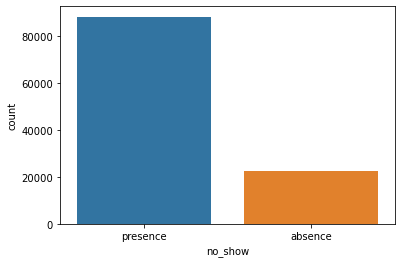

In [58]:
sb.countplot(data = df, x = 'no_show');
plt.xticks([0,1],['presence','absence']);

> define a function to calculate the `no_show_rate` groupby feature:

In [60]:
#define a function to calculate the no_show_rate groupby feature
def no_show_rate(feature):
    print(df.groupby(feature)['no_show'].mean())
 

> calculate the `no_show rate` under different features.

In [14]:
no_show_rate('gender')

gender
F    0.203146
M    0.199679
Name: no_show, dtype: float64


It seems like female has higher no-show rate here, and next I will explore the other factors the same way.

In [15]:
df.groupby('neighbourhood')['no_show'].mean().sort_values()

neighbourhood
PARQUE INDUSTRIAL              0.000000
ILHA DO BOI                    0.085714
AEROPORTO                      0.125000
MÁRIO CYPRESTE                 0.145553
SOLON BORGES                   0.147122
                                 ...   
ITARARÉ                        0.262664
SANTA CLARA                    0.264822
SANTA CECÍLIA                  0.274554
SANTOS DUMONT                  0.289185
ILHAS OCEÂNICAS DE TRINDADE    1.000000
Name: no_show, Length: 81, dtype: float64

It has too many different neighbourhood and it's hard to distinguish if a neighour has better showing up rate since each neighborhood has different number of patients. For example, if a neighourhood has only one patient, then the no_show rate totally depend on if that patient showed up or not!

In [35]:
no_show_rate('scholarship')

scholarship
0    0.198072
1    0.237363
Name: no_show, dtype: float64


The patients who enrolled in Brasilian welfare program Bolsa Família has higher no-show rate, which is contrary to what I thought. That's quiet interesting!

In [34]:
no_show_rate('hipertension')

hipertension
0    0.209037
1    0.173020
Name: no_show, dtype: float64


In [32]:
no_show_rate('diabetes')

diabetes
0    0.203628
1    0.180033
Name: no_show, dtype: float64


In [31]:
no_show_rate('alcoholism')

alcoholism
0    0.201946
1    0.201488
Name: no_show, dtype: float64


It seems like patients with disease has lower no-show rate. It's reasonable because they may have more health concerns that have to get treated. 

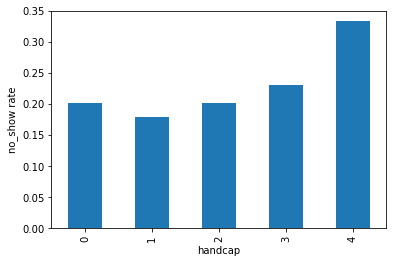

In [39]:
df.groupby('handcap')['no_show'].mean().plot(kind = 'bar');
plt.ylabel('no_show rate');

The patients with higher level disabilities tend to not showing up. It makes sense because they may be less convenient going out. 

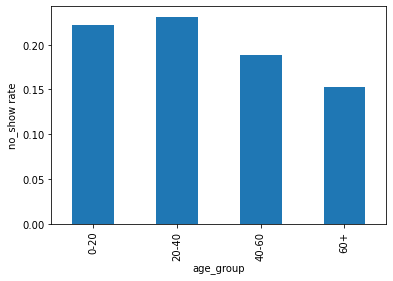

In [37]:
df.groupby('age_group')['no_show'].mean().plot(kind = 'bar');
plt.ylabel('no_show rate');

It seems that the patients with age in between 20-40 have highest no-show rate. The patients who are greater than 60 yeas old have lowest no-show rate.

In [42]:
df.date_diff.min()

Timedelta('-6 days +00:00:00')

In [23]:
df[df.date_diff == df.date_diff.min()]

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_group,date_diff
71533,9.982316e+14,5686628,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,1,60+,-6 days


Actually we have some bad records here. It looks like the scheduled day is before appointmentday. And it's difinitely no show up. I will group the date_diff with 6 days frequency that date_diff is less than 0 days can be in one group.

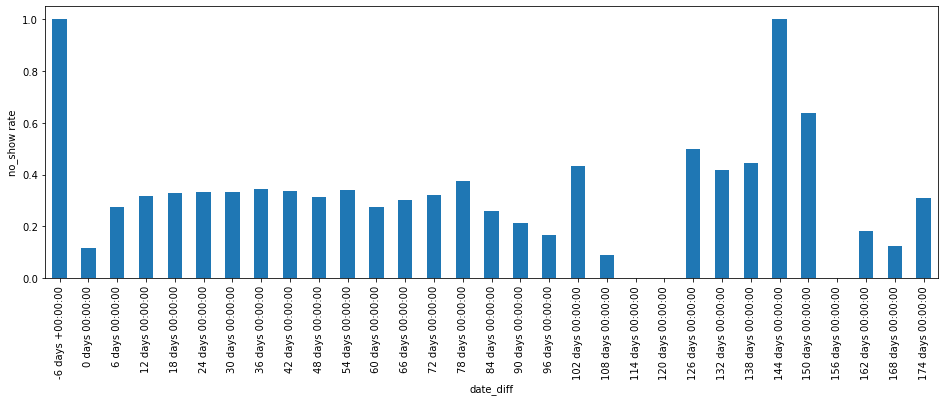

In [46]:
df.groupby(pd.Grouper(key='date_diff',freq='6D')).no_show.mean().plot(kind = 'bar',figsize = (16,5));
plt.ylabel('no_show rate');

From above picture, we see that if date_difference < 0, then the no_show rate is definitely 1. 
for date_difference in between 0-6, it has much lower no show rate compare to other groups. 
For those groups with date_difference too big, such as date_diff > 90 days, they tend to have much higher no show rate. However I don't really think they are really informative since they have much less patient samples compare to the groups with date_diff < 90. The below sample counts can show you the sample size of each group.

In [61]:
df.groupby(pd.Grouper(key='date_diff',freq='6D')).no_show.count()

date_diff
-6 days         5
0 days      61805
6 days      15258
12 days      9471
18 days      7108
24 days      5798
30 days      4397
36 days      1847
42 days      1195
48 days       792
54 days       683
60 days       773
66 days       562
72 days       319
78 days        93
84 days       146
90 days       126
96 days        12
102 days       23
108 days       22
114 days        7
120 days        5
126 days        2
132 days       12
138 days        9
144 days        1
150 days       11
156 days        0
162 days       11
168 days        8
174 days       26
Freq: 6D, Name: no_show, dtype: int64

I actually quite interesting about the no-show rate for the date_diff in between (0,10), so I did another comparisons within this group.

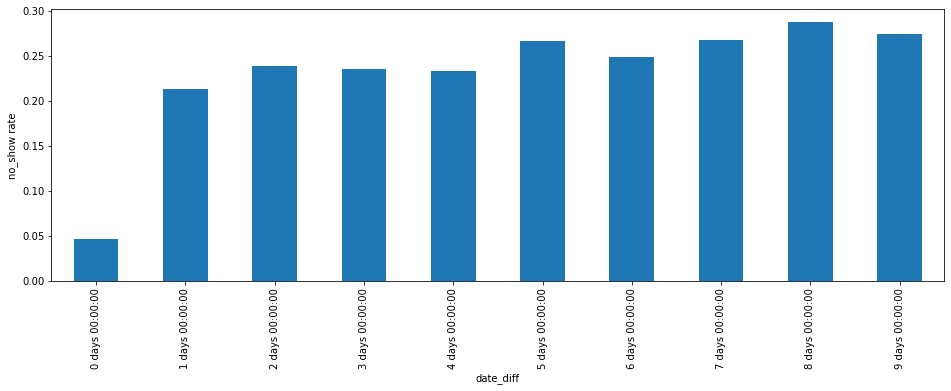

In [44]:
df[(df.date_diff < '10 days') & (df.date_diff >= '0 days')].groupby('date_diff').no_show.mean().plot(kind = 'bar',figsize = (16,5));
plt.ylabel('no_show rate');

Then I found if the date_diff is 0 days, then the no_show rate is really low. and the longer it take to wait, the higher the no show rate is. But it tend to steady fast around the average no_show rate(as I mentioned before, it equals 0.2019) with small oscillation.

### If age and date_diff have correlations?

In [27]:
df['date_diff_num'] = df.date_diff.astype(str).str.extract('(\d+)').astype(int)
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_group,date_diff,date_diff_num
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,60+,0 days,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,40-60,0 days,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,60+,0 days,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0-20,0 days,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,40-60,0 days,0


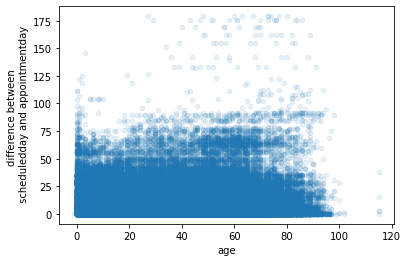

In [69]:
df.plot(x = 'age',y = 'date_diff_num',kind = 'scatter', alpha = 0.1);
plt.ylabel('difference between \n scheduledday and appointmentday');

It seems like they have no correlation at all! but nice try. I think that all for my exploration.

<a id='conclusions'></a>
## Conclusions
> - It seems that female has higher no-show rate, the patients who enrolled in Brasilian welfare program Bolsa Família has higher no-show rate, the patients with disease have lower no-show rate. It's reasonable because they may have more health concerns that have to get treated. And The patients with higher level disabilities tend to not showing up. It makes sense because they may be less convenient going out. 

> - For neighborhood, It has too many different neighborhood and it's hard to distinguish if a neighbor has better showing up rate since each neighborhood has different number of patients. For example, if a neighborhood has only one patient, then the no_show rate totally depend on if that patient showed up or not!

> - The ages may influence no-show rate as well, It seems that the patients with age in between 20-40 have highest no-show rate. The patients who are greater than 60 yeas old have lowest no-show rate. 

> - The time gap between scheduled day and appointment day may have little influence on no-show rate. Except 0 day gap. That may be caused by patients are actually already in hospital. And it is much easier for them to wait in hospital than come back few days later.

> - All the results are not based on Hypothesis test so it could only be used as reference.

**Recall my question:**
> - What factors influences the no_show rate? 

**Answer:**
> - From the exploratory part, the no_show rate calculated simply based on sample mean. However, the sample data is limited and unbalanced. For example, the age groups have different sizes. So we can't draw conclusion without hypothesis test. 